In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/valid'
test_dir = '/content/drive/MyDrive/dataset/test'


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_data = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['Degradable', 'Non degradable']


In [ ]:
model = models.vgg19(pretrained=True)

# Freeze convolution layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.4MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


Epoch 1/5 - Loss: 0.2091 - Accuracy: 0.9116
Epoch 2/5 - Loss: 0.0448 - Accuracy: 0.9834
Epoch 3/5 - Loss: 0.0406 - Accuracy: 0.9890
Epoch 4/5 - Loss: 0.0122 - Accuracy: 0.9972
Epoch 5/5 - Loss: 0.0038 - Accuracy: 0.9986


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.89%


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/vgg19_waste_model.pth')


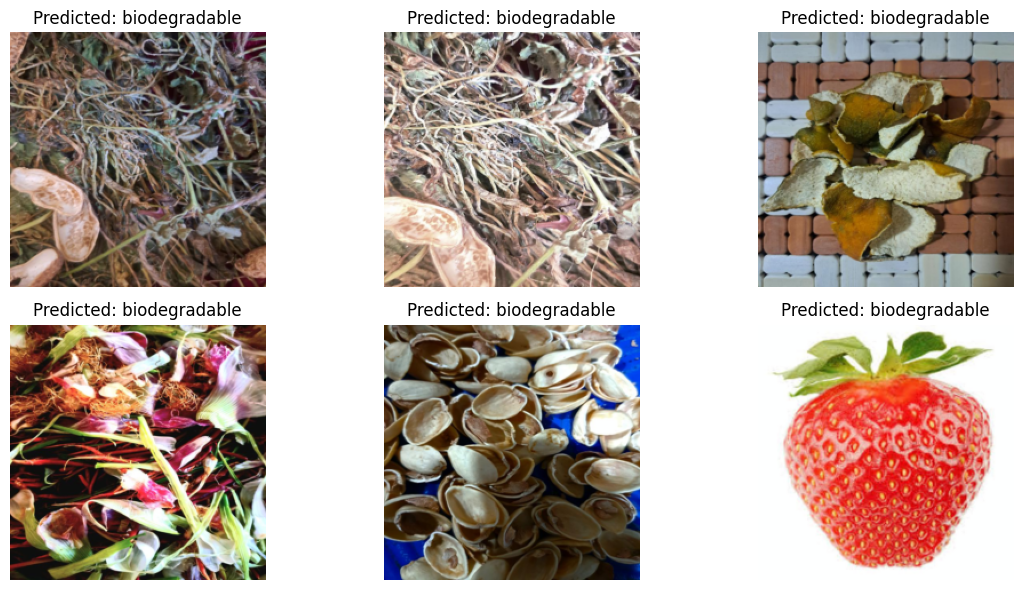

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to GPU/CPU
images = images.to(device)
labels = labels.to(device)

# Run the model
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Correct class labels
class_names = ['biodegradable', 'non_biodegradable']

# Display predictions
plt.figure(figsize=(12, 6))
for idx in range(6):  # Display 6 test images
    ax = plt.subplot(2, 3, idx + 1)
    imshow(images[idx].cpu(), title=f"Predicted: {class_names[preds[idx]]}")
plt.tight_layout()
plt.show()
